## **Calssification Finetuning**

Model is finetuned to recognize specific set of labels / classes

---
### **Dataset Preparation for Spam Classification**
---
Dataset for spam emails is downloaded from Kaggle

In [1]:
import pandas as pd 
import numpy as np

df = pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
# How many unique categories of email we have 
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [3]:
# This dataset is imbalanced, lets make it balanced
ham_emails = len(df[df['Category'] == 'ham'])
spam_emails = len(df[df['Category'] == 'spam'])

# Randomly sample 'ham' instances to match 'spam' instances 
ham_subset = df[df['Category'] == 'ham'].sample(spam_emails, random_state=42)

balanced_df = pd.concat([df[df['Category'] == 'spam'], ham_subset], axis=0)
# unique catgeories in balanced_df 
print(balanced_df['Category'].value_counts())

Category
spam    747
ham     747
Name: count, dtype: int64


In [4]:
# Converting the string labels to numbers
balanced_df['Category'] = balanced_df['Category'].map({'ham':0, 'spam':1})
balanced_df.head()

,Category,Message
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
5,1,FreeMsg Hey there darling it's been 3 week's n...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...
11,1,"SIX chances to win CASH! From 100 to 20,000 po..."


In [5]:
# splitting data into train, test, and val 

# Step1 : Shuffle the data 
balanced_df = balanced_df.sample(frac=1, random_state=42)

train_data = balanced_df[:int(0.7*len(balanced_df))]
val_data   = balanced_df[int(0.7*len(balanced_df)):int(0.8*len(balanced_df))]
test_data  = balanced_df[int(0.8*len(balanced_df)):]

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

print(f"Length of Train data : {len(train_data)}")
print(f"Length of validation data : {len(val_data)}")
print(f"Length of test data : {len(test_data)}")

Length of Train data : 1045
Length of validation data : 150
Length of test data : 299


In [6]:
train_data.head()

,Category,Message
0,0,The evo. I just had to download flash. Jealous?
1,0,Hi Dear Call me its urgnt. I don't know whats ...
2,0,Full heat pa:-) i have applyed oil pa.
3,0,Gokila is talking with you aha:)
4,0,"Dude u knw also telugu..thts gud..k, gud nyt.."


##### **Dataset and DataLoader**

In [7]:
import torch 
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=None, pad_token_id=50526):
        self.encoded_text = [tokenizer.encode(row_data) for row_data in data['Message']]
        self.labels = data['Category'].tolist()
        # now I need to add padding as per max_length 
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
        
        # truncate the tokenized sentences to max_length
        self.encoded_text = [encoded_text[:max_length] for encoded_text in self.encoded_text]

        # padding sentences to max_length
        self.encoded_text = [encoded_text + [pad_token_id]*(self.max_length - len(encoded_text)) for encoded_text in self.encoded_text]

    def _longest_encoded_length(self):
        max_len = 0
        for i in range(len(self.encoded_text)):
            if len(self.encoded_text[i]) > max_len:
                max_len = len(self.encoded_text[i])
        return max_len
    
    def __len__(self):
        return len(self.encoded_text)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.encoded_text[idx], dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.long)
        )

In [8]:
# Making dataloader that allows to arrange inputs in batches and shuffle them
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

train_dataset = CustomDataset(train_data, tokenizer)
test_dataset = CustomDataset(test_data, tokenizer)
valid_dataset = CustomDataset(val_data, tokenizer)

# for reproducibility
torch.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)
val_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True, drop_last=True)

In [9]:
print(f"Total training batches : {len(train_loader)}")
print(f"Total validation batches : {len(val_loader)}")
print(f"Total testing batches : {len(test_loader)}")

Total training batches : 261
Total validation batches : 37
Total testing batches : 74


In [10]:
# Looking at the batches
batch1 = next(iter(val_loader))
X, y = batch1
print(f"Features : {X.shape}")
print(f"Labels : {y.shape}")

Features : torch.Size([4, 58])
Labels : torch.Size([4])


---

### **Model Setup**
---
- In this we'll load pretrained weights of GPT2 model 
- Modify the model for finetuning
- Implement some evaluation utilities

In [11]:
BASE_CONFIG = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "drop_rate" : 0.0,
    "qkv_bias" : True,
    "emb_dim" : 768,
    "n_layers" : 12,
    "n_heads" : 12
}

In [ ]:
from GPT2_architecture import GPTModel
from gpt_download3 import load_params

# you need to first download the params, USE BELOW LINES
# from gpt_download3 import download_and_load_gpt2
# settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

# I had already downloaded weights so I wrote a function load_params 
settings, params = load_params("gpt2/124M")

In [13]:
import torch

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [14]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In [15]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

device

'mps'

In [16]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.to(device)
model.eval();

In [17]:
# lets check this model 
inputs = torch.randint(0, 50256, (2, 10))

with torch.no_grad():
    model.eval()
    output = model(inputs.to(device))
    print(output.shape)

torch.Size([2, 10, 50257])


#### **How we'll apply classification**

For this we need to change the last layer of network, if we recall last layer contains feed forward neural network which convert [embedding_dim - 768] to [vocab_size - 50256]

Now we'll add a feed forward layer that converts this [50256] vector to a dimension of [2]
which represent spam and ham

and this time we'll not finetune whole architecture , we'll only train this last layer 

We can also finetune these : 
- final output layer 
- final transformer block 
- final layer norm layer

We'll freeze other weights while finetuning

In [18]:
# print original architecture 
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

See the last layer : 

(out_head): Linear(in_features=768, out_features=50257, bias=False)

In [19]:
## freeze the non_trainable weights
## this freeze all the parameters of the model
for param in model.parameters():
    param.require_grad = False

In [20]:
# will replace output layer which previously maps from 768 -> 50256 to (768 -> 2)
num_categories = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG['emb_dim'], out_features=num_categories).to(device)

# by default the require_grads is True for this 
# we can do it manually
for param in model.out_head.parameters():
    param.requires_grad = True

In [21]:
# we'll make require_grad = True for final transformer layer and layer_norm 
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.require_grad = True

In [22]:
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [23]:
# now lets check if model is working correctly or not
inputs = torch.randint(0, 50256, (2, 4))
model.eval()
with torch.no_grad():
    output = model(inputs.to(device))

print(output.shape)

torch.Size([2, 4, 2])


In [24]:
# last output token
output[:, -1, :]

tensor([[ 0.8341, -2.8079],
        [ 0.5133, -3.9093]], device='mps:0')

#### **Calculating Classification Loss and Accuracy**

In [25]:
labels = torch.zeros(2, 1)
labels

tensor([[0.],
        [0.]])

In [26]:
logits = output[:, -1, :]
logits

tensor([[ 0.8341, -2.8079],
        [ 0.5133, -3.9093]], device='mps:0')

In [27]:
probs = torch.softmax(logits, dim=-1)
probs

tensor([[0.9745, 0.0255],
        [0.9881, 0.0119]], device='mps:0')

In [28]:
torch.argmax(probs, dim=-1)

tensor([0, 0], device='mps:0')

In [29]:
# function to calculate accuracy

def calculate_accuracy(data_loader, model, device):
    total_examples = 0
    correct_preds = 0
    model.eval()
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        
        with torch.no_grad():
            preds = model(X)
            preds = preds[:, -1, :]

        
        probs = torch.argmax(preds, dim=-1)
        total_examples += preds.shape[0]
        correct_preds += (probs == y).sum().item()
    
    return correct_preds / total_examples

In [30]:
# lets check accuracy before training 
acc = calculate_accuracy(test_loader, model, device)
print(f"Accuracy before training is : {acc*100:.2f}%")

Accuracy before training is : 70.61%


In [31]:
# function to calculate batch loss
def calculate_batch_loss(preds_batch, target_batch):
    logits = preds_batch[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


## **Training Loop**

In [32]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
epochs = 2

In [33]:
import os
os.makedirs('./classifications_checkpoints', exist_ok=True)

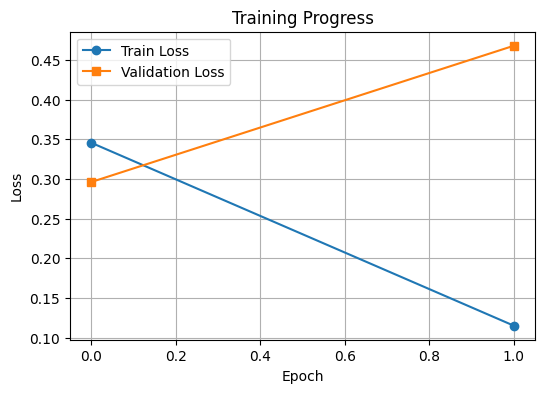

Epoch 2/2 | Train : 0.1151 | Val : 0.4677


In [34]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

train_loss = []
val_loss = []

for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    model.train()
    ## training loop ##
    for X, y in tqdm(train_loader):
        X, y = X.to(device), y.to(device)
        preds = model(X)
        loss = calculate_batch_loss(preds, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_loss.append(epoch_train_loss)

    ## validation loop ##
    with torch.no_grad():
        model.eval()
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = calculate_batch_loss(preds, y)
            epoch_val_loss += loss.item()

    epoch_val_loss /= len(val_loader)
    val_loss.append(epoch_val_loss)

    clear_output(wait=True)
    plt.figure(figsize=(6,4))
    plt.plot(train_loss, label='Train Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='s')
    plt.title('Training Progress')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    torch.save(model.state_dict(), './classifications_checkpoints/classification_finetuned_gpt_model.pth')
    print(f"Epoch {epoch+1}/{epochs} | Train : {train_loss[-1]:.4f} | Val : {val_loss[-1]:.4f}")



In [37]:
# lets check accuracy before training 
acc = calculate_accuracy(test_loader, model, device)
print(f"Accuracy before training is : {acc*100:.2f}%")

Accuracy before training is : 95.95%


## **Accuracy of 95% ⭐️**